In [1]:
!unzip -qq Face_Dataset.zip

In [1]:
!pip install facenet-pytorch

In [1]:
from utils.dataset import SiameseDataset
from utils.loss import ContrastiveLoss
from utils.model import SiameseModel
from torch.utils.data import DataLoader
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from torchvision import transforms
from tqdm import tqdm

In [2]:
df = pd.read_csv("image_pairs.csv")

In [3]:
df

,image1,image2,label
0,Face_Dataset/1170/1.jpg,Face_Dataset/1170/8.jpg,1
1,Face_Dataset/1678/1.jpg,Face_Dataset/1376/7.jpg,0
2,Face_Dataset/1092/2.jpg,Face_Dataset/1092/6.jpg,1
3,Face_Dataset/1082/26.jpg,Face_Dataset/1082/28.jpg,1
4,Face_Dataset/164/5.jpg,Face_Dataset/1667/1.jpg,0
...,...,...,...
19995,Face_Dataset/1265/2.jpg,Face_Dataset/1321/3.jpg,0
19996,Face_Dataset/85/5.jpg,Face_Dataset/787/2.jpg,0
19997,Face_Dataset/1152/11.jpg,Face_Dataset/1152/4.jpg,1
19998,Face_Dataset/608/2.jpg,Face_Dataset/1579/1.jpg,0


In [4]:
df['label'].value_counts()

,count
label,
1,10000
0,10000


In [5]:
train_df, val_df= train_test_split(df, test_size=0.2,random_state=100)

In [6]:
train_df['label'].value_counts()

,count
label,
1,8001
0,7999


In [7]:
val_df['label'].value_counts()

,count
label,
0,2001
1,1999


In [8]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

In [9]:
train_dataset = SiameseDataset(train_df, transform=transform)
val_dataset = SiameseDataset(val_df, transform=transform)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
device

device(type='cuda')

In [13]:
model = SiameseModel().to(device)

In [14]:
model

SiameseModel(
  (model): InceptionResnetV1(
    (conv2d_1a): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2a): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2b): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2d_3b): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, t

In [15]:
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []
lr_track = []

def train_model(model, train_loader, criterion, optimizer, device, epochs, patience = 5):
    model.train()

    best_val_loss = float('inf')  # Set to a large number initially
    patience_counter = 0  # Counter to track how long validation loss has not improved
    #Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, min_lr=0.0001)

    for epoch in range(epochs):
        train_loss = 0.0
        total = 0
        correct = 0

        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            for batch_idx, (image1, image2, label) in enumerate(train_loader):

                image1, image2, label = image1.to(device), image2.to(device), label.to(device)

                optimizer.zero_grad()

                output1, output2 = model(image1, image2)

                #Loss Calculation
                loss = criterion(output1, output2, label)
                train_loss += loss.item()

                loss.backward()
                optimizer.step()

                # Calculate the distance
                distance = torch.nn.functional.pairwise_distance(output1, output2)
                predicted = (distance < 0.4).float()  # Adjust the threshold as needed

                total += label.size(0)
                correct += predicted.eq(label).sum().item()

                # Update progress bar
                pbar.set_postfix(loss=train_loss / (pbar.n + 1))
                pbar.update(1)

        # print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")
        record_loss = train_loss/len(train_loader)
        record_accuracy = 100*correct/total
        train_losses.append(record_loss)
        train_accuracy.append(record_accuracy)

        current_lr = optimizer.param_groups[0]['lr']
        lr_track.append(current_lr)


        val_loss = validate_model(model, val_loader, criterion, device)

        # Step the scheduler after each optimizer step
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset the counter if validation loss improves
            best_model_state = model.state_dict()  # Save the best model
            best_epoch = epoch + 1  # Track the epoch number (1-based index)
            # Save the model's state dictionary
            torch.save(model.state_dict(), 'model_weights_rmsprop.pth')
            print(f"Best model saved at epoch {best_epoch} with validation loss {val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"Validation loss did not improve for {patience_counter} epoch(s).")

        # Stop training if patience is exceeded
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            model.load_state_dict(best_model_state)  # Load the best model state before overfitting occurred
            print(f"Model restored from epoch {best_epoch} with the best validation loss {best_val_loss:.4f}")
            break


In [16]:
distances = []
labels = []
def validate_model(model, val_loader, criterion, device):
    model.eval()
    validation_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc="Validation", unit="batch") as pbar:
            for batch_idx, (image1, image2, label) in enumerate(val_loader):

                image1, image2, label = image1.to(device), image2.to(device).to(device), label.to(device)

                output1, output2 = model(image1, image2)

                loss = criterion(output1, output2, label)
                validation_loss += loss.item()

                # Calculate the distance
                distance = torch.nn.functional.pairwise_distance(output1, output2)
                predicted = (distance < 0.4).float()  # Adjust the threshold as needed

                #Necessary Data for ROC Curve for best threshold
                distances.extend(distance.cpu().numpy())
                labels.extend(label.cpu().numpy())


                # Update correct predictions
                correct += (predicted == label).sum().item()
                total += label.size(0)

                # Update progress bar
                pbar.set_postfix(val_loss=validation_loss / (pbar.n + 1))
                pbar.update(1)


    record_loss = validation_loss/len(val_loader)
    record_accuracy = 100*correct/total
    val_losses.append(record_loss)
    val_accuracy.append(record_accuracy)
#     print(f"Validation Accuracy: {record_accuracy:.2f}%")

    return record_loss



In [17]:
criterion = ContrastiveLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, momentum = 0.9, weight_decay=1e-5)
train_model(model, train_loader, criterion, optimizer, device, epochs=20)

Validation: 100%|██████████| 125/125 [00:34<00:00,  3.58batch/s, val_loss=0.171]


Best model saved at epoch 1 with validation loss 0.1705


Validation: 100%|██████████| 125/125 [00:35<00:00,  3.54batch/s, val_loss=0.224]


Validation loss did not improve for 1 epoch(s).


Validation: 100%|██████████| 125/125 [00:35<00:00,  3.50batch/s, val_loss=0.162]


Best model saved at epoch 3 with validation loss 0.1617


Validation: 100%|██████████| 125/125 [00:35<00:00,  3.56batch/s, val_loss=0.141]


Best model saved at epoch 4 with validation loss 0.1406


Validation: 100%|██████████| 125/125 [00:34<00:00,  3.61batch/s, val_loss=0.116]


Best model saved at epoch 5 with validation loss 0.1157


Validation: 100%|██████████| 125/125 [00:35<00:00,  3.50batch/s, val_loss=0.093]


Best model saved at epoch 6 with validation loss 0.0930


Validation: 100%|██████████| 125/125 [00:34<00:00,  3.57batch/s, val_loss=0.0856]


Best model saved at epoch 7 with validation loss 0.0856


Validation: 100%|██████████| 125/125 [00:35<00:00,  3.55batch/s, val_loss=0.0701]


Best model saved at epoch 8 with validation loss 0.0701


Validation: 100%|██████████| 125/125 [00:34<00:00,  3.60batch/s, val_loss=0.0691]


Best model saved at epoch 9 with validation loss 0.0691


Validation: 100%|██████████| 125/125 [00:35<00:00,  3.56batch/s, val_loss=0.073]


Validation loss did not improve for 1 epoch(s).


Validation: 100%|██████████| 125/125 [00:36<00:00,  3.46batch/s, val_loss=0.0619]


Best model saved at epoch 11 with validation loss 0.0619


Validation: 100%|██████████| 125/125 [00:34<00:00,  3.57batch/s, val_loss=0.0649]


Validation loss did not improve for 1 epoch(s).


Validation: 100%|██████████| 125/125 [00:34<00:00,  3.59batch/s, val_loss=0.0691]


Validation loss did not improve for 2 epoch(s).


Validation: 100%|██████████| 125/125 [00:34<00:00,  3.57batch/s, val_loss=0.0606]


Best model saved at epoch 14 with validation loss 0.0606


Validation: 100%|██████████| 125/125 [00:34<00:00,  3.61batch/s, val_loss=0.0642]


Validation loss did not improve for 1 epoch(s).


Validation: 100%|██████████| 125/125 [00:34<00:00,  3.57batch/s, val_loss=0.0614]


Validation loss did not improve for 2 epoch(s).


Validation: 100%|██████████| 125/125 [00:35<00:00,  3.56batch/s, val_loss=0.0579]


Best model saved at epoch 17 with validation loss 0.0579


Validation: 100%|██████████| 125/125 [00:34<00:00,  3.57batch/s, val_loss=0.0588]


Validation loss did not improve for 1 epoch(s).


Validation: 100%|██████████| 125/125 [00:35<00:00,  3.57batch/s, val_loss=0.0587]


Validation loss did not improve for 2 epoch(s).


Validation: 100%|██████████| 125/125 [00:34<00:00,  3.59batch/s, val_loss=0.0585]

Validation loss did not improve for 3 epoch(s).


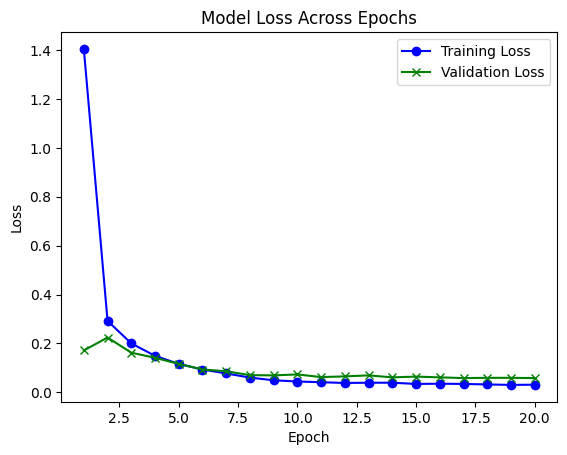

In [18]:
# Function to plot two lists of loss values for each epoch
def plot_loss_curves(train_losses, val_losses):
    # Round the values to 2 decimal places
    train_losses = [round(num, 3) for num in train_losses]
    val_losses =  [round(num, 3) for num in val_losses]


    # Epochs (1 to 10)
    epochs = range(1, len(val_losses)+1)

    # Plotting the losses of both models
    plt.plot(epochs, train_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', color='green', marker='x')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss Across Epochs')

    # Adding a legend
    plt.legend()

    # Display the plot
    plt.show()

# Example usage
plot_loss_curves(train_losses, val_losses)

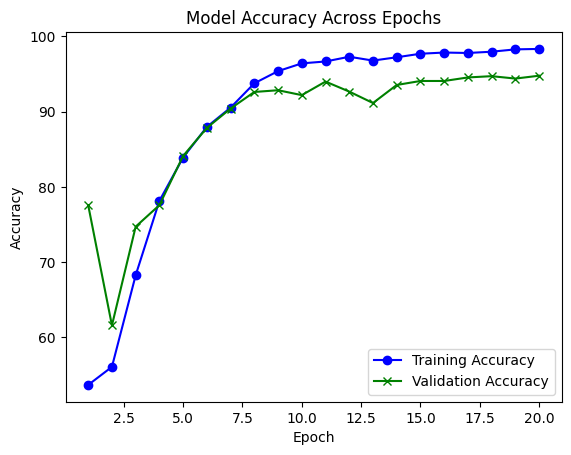

In [19]:
# Function to plot two lists of loss values for each epoch
def plot_accuracy_curves(train_accuracy, val_accuracy):
    # Round the values to 2 decimal places
    train_accuracy = [round(num, 2) for num in train_accuracy]
    val_accuracy =  [round(num, 2) for num in val_accuracy]


    # Epochs (1 to 10)
    epochs = range(1, len(val_accuracy)+1)

    # Plotting the losses of both models
    plt.plot(epochs, train_accuracy, label='Training Accuracy', color='blue', marker='o')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='green', marker='x')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Across Epochs')

    # Adding a legend
    plt.legend()

    # Display the plot
    plt.show()

# Example usage
plot_accuracy_curves(train_accuracy, val_accuracy)

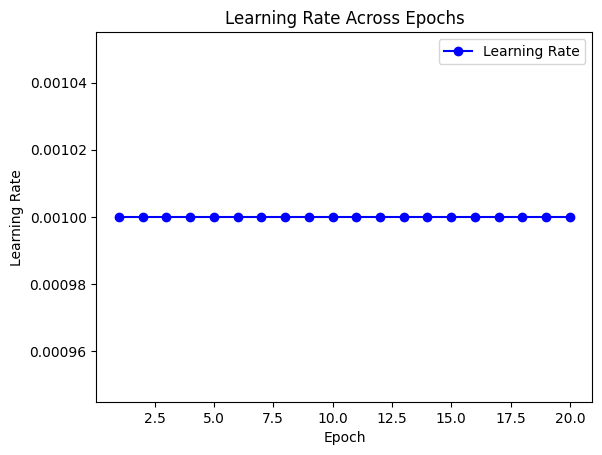

In [20]:
# Function to plot two lists of loss values for each epoch
def plot_lr_curve(lr_track):

    lr = lr_track

    # Epochs (1 to 10)
    epochs = range(1, len(lr)+1)

    # Plotting the learning rate of the model
    plt.plot(epochs, lr, label='Learning Rate', color='blue', marker='o')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Across Epochs')

    # Adding a legend
    plt.legend()

    # Display the plot
    plt.show()

# Example usage
plot_lr_curve(lr_track)

In [21]:
print(lr_track)

[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]


In [22]:
print(val_accuracy)

[77.575, 61.6, 74.725, 77.575, 84.125, 87.85, 90.425, 92.625, 92.85, 92.2, 94.0, 92.675, 91.15, 93.55, 94.075, 94.075, 94.55, 94.725, 94.4, 94.775]


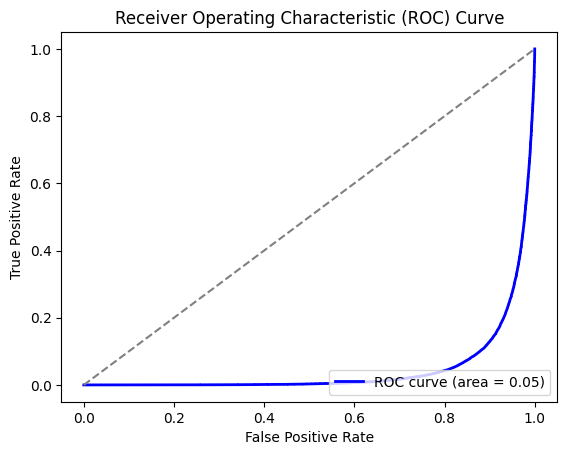

In [23]:
# Plot ROC Curve
def plot_roc_curve(labels, distances):
    fpr, tpr, thresholds = roc_curve(labels, distances)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(labels, distances)